Mounted at /content/gdrive
/content/gdrive/My Drive/Project FPAR2/ego-rnn
importing Jupyter notebook from objectAttentionModelLSTA.ipynb
importing Jupyter notebook from MyConvLSTACell.ipynb
importing Jupyter notebook from resNetNew.ipynb
importing Jupyter notebook from spatial_transforms.ipynb
importing Jupyter notebook from makeDatasetRGB.ipynb
importing Jupyter notebook from resnetMod.ipynb
importing Jupyter notebook from plotting.ipynb


MyConvLSTACell.ipynb:49: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
MyConvLSTACell.ipynb:50: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
MyConvLSTACell.ipynb:51: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
MyConvLSTACell.ipynb:53: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
MyConvLSTACell.ipynb:54: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
MyConvLSTACell.ipynb:55: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
MyConvLSTACell.ipynb:57: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
MyConvLSTACell.ipynb:58: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
MyConvLSTACell.ipynb:59: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
MyCo

Train: Epoch = 1 | Loss = 4.110229015350342 | Accuracy = 3.225806451612903


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:199: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:200: UserWarning: This overload of cuda is deprecated:
	cuda(torch.device device, bool async, *, torch.memory_format memory_format)
Consider using one of the following signatures instead:
	cuda(torch.device device, bool non_blocking, *, torch.memory_format memory_format) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:200: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Val: Epoch = 1 | Loss 4.015614032745361 | Accuracy = 6.0344827586206895
Train: Epoch = 2 | Loss = 4.1297688484191895 | Accuracy = 3.519061583577713
Val: Epoch = 2 | Loss 3.9491167068481445 | Accuracy = 6.0344827586206895
Train: Epoch = 3 | Loss = 4.028736591339111 | Accuracy = 5.278592375366569
Val: Epoch = 3 | Loss 3.9743051528930664 | Accuracy = 4.310344827586207
Train: Epoch = 4 | Loss = 4.036126136779785 | Accuracy = 5.571847507331378
Val: Epoch = 4 | Loss 3.9264750480651855 | Accuracy = 3.4482758620689653
Train: Epoch = 5 | Loss = 4.108560085296631 | Accuracy = 4.105571847507331
Val: Epoch = 5 | Loss 3.8932032585144043 | Accuracy = 9.482758620689655
Train: Epoch = 6 | Loss = 3.986128807067871 | Accuracy = 6.158357771260997
Val: Epoch = 6 | Loss 3.8095953464508057 | Accuracy = 9.482758620689655
Train: Epoch = 7 | Loss = 3.9848315715789795 | Accuracy = 7.331378299120235
Val: Epoch = 7 | Loss 3.7670111656188965 | Accuracy = 10.344827586206897
Train: Epoch = 8 | Loss = 3.9551806449890

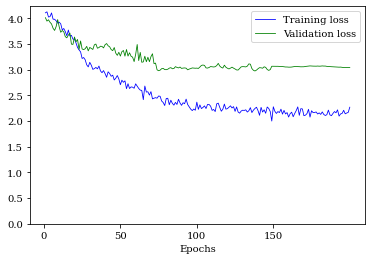

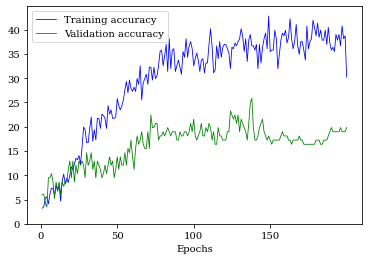

In [1]:
!pip install import_ipynb
import import_ipynb
from google.colab import drive
drive.mount('/content/gdrive',  force_remount=True)
%cd /content/gdrive/My Drive/Project FPAR2/ego-rnn

from __future__ import print_function, division
#from objectAttentionModelConvLSTM import *
from objectAttentionModelLSTA import *
from spatial_transforms import (Compose, ToTensor, CenterCrop, Scale, Normalize, MultiScaleCornerCrop,
                                RandomHorizontalFlip)
!pip install tensorboardX
from tensorboardX import SummaryWriter
#from MyConvGruCell import *
from makeDatasetRGB import *
import argparse
import sys
from resnetMod import *
from plotting import *

def main_run(dataset, stage, train_data_dir, val_data_dir, stage1_dict, out_dir, seqLen, trainBatchSize,
             valBatchSize, numEpochs, lr1, decay_factor, decay_step, memSize, cam):

    if dataset == 'gtea61':
        num_classes = 61
    elif dataset == 'gtea71':
      num_classes = 71
    elif dataset == 'gtea_gaze':
        num_classes = 44
    elif dataset == 'egtea':
        num_classes = 106
    else:
        print('Dataset not found')
        sys.exit()

    model_folder = out_dir  # Dir for saving models and log files
    

    # Log files
    writer = SummaryWriter(model_folder)
    train_log_loss = open((model_folder + '/train_log_loss.txt'), 'w')
    train_log_acc = open((model_folder + '/train_log_acc.txt'), 'w')
    val_log_loss = open((model_folder + '/val_log_loss.txt'), 'w')
    val_log_acc = open((model_folder + '/val_log_acc.txt'), 'w')


    # Data loader
    normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    spatial_transform = Compose([Scale(256), RandomHorizontalFlip(), MultiScaleCornerCrop([1, 0.875, 0.75, 0.65625], 224), ToTensor(), normalize])
    from torchvision.transforms import Resize
    spatial_transform_mmap = Compose([Resize(256),ToTensor()])
    vid_seq_train = makeDataset(train_data_dir,
                                spatial_transform=spatial_transform, seqLen=seqLen, fmt='.png')

    train_loader = torch.utils.data.DataLoader(vid_seq_train, batch_size=trainBatchSize,
                            shuffle=True, num_workers=4, pin_memory=True)
    if val_data_dir is not None:

        vid_seq_val = makeDataset(val_data_dir,
                                   spatial_transform=Compose([Scale(256), CenterCrop(224), ToTensor(), normalize]),
                                   seqLen=seqLen, train=False, fmt='.png')

        val_loader = torch.utils.data.DataLoader(vid_seq_val, batch_size=valBatchSize,
                                shuffle=False, num_workers=2, pin_memory=True)
        valInstances = vid_seq_val.__len__()


    trainInstances = vid_seq_train.__len__()

    train_params = []
    if stage == 1:

        model = attentionModel(num_classes=num_classes, mem_size=memSize)
        model.train(False)
        for params in model.parameters():
            params.requires_grad = False
    else:

        model = attentionModel(num_classes=num_classes, mem_size=memSize)
        model.load_state_dict(torch.load(stage1_dict))
        model.train(False)
        for params in model.parameters():
            params.requires_grad = False
        #
        for params in model.resNet.layer4[0].conv1.parameters():
            params.requires_grad = True
            train_params += [params]

        for params in model.resNet.layer4[0].conv2.parameters():
            params.requires_grad = True
            train_params += [params]

        for params in model.resNet.layer4[1].conv1.parameters():
            params.requires_grad = True
            train_params += [params]

        for params in model.resNet.layer4[1].conv2.parameters():
            params.requires_grad = True
            train_params += [params]

        for params in model.resNet.layer4[2].conv1.parameters():
            params.requires_grad = True
            train_params += [params]
        #
        for params in model.resNet.layer4[2].conv2.parameters():
            params.requires_grad = True
            train_params += [params]
        #
        for params in model.resNet.fc.parameters():
            params.requires_grad = True
            train_params += [params]

        model.resNet.layer4[0].conv1.train(True)
        model.resNet.layer4[0].conv2.train(True)
        model.resNet.layer4[1].conv1.train(True)
        model.resNet.layer4[1].conv2.train(True)
        model.resNet.layer4[2].conv1.train(True)
        model.resNet.layer4[2].conv2.train(True)
        model.resNet.fc.train(True)

    for params in model.lsta_cell.parameters():
        params.requires_grad = True
        train_params += [params]

    for params in model.classifier.parameters():
        params.requires_grad = True
        train_params += [params]

    model.lsta_cell.train(True)
    model.classifier.train(True)
    model.cuda()

    loss_fn = nn.CrossEntropyLoss()

    optimizer_fn = torch.optim.Adam(train_params, lr=lr1, weight_decay=4e-5, eps=1e-4)

    optim_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer_fn, milestones=decay_step,
                                                           gamma=decay_factor)
    
    train_loss_list=[]
    val_loss_list=[]
    train_acc_list=[]
    val_acc_list=[]

    train_iter = 0
    min_accuracy = 0

    for epoch in range(numEpochs):
        optim_scheduler.step()
        epoch_loss = 0
        numCorrTrain = 0
        trainSamples = 0
        iterPerEpoch = 0
        model.lsta_cell.train(True)
        model.classifier.train(True)
        writer.add_scalar('lr', optimizer_fn.param_groups[0]['lr'], epoch+1)
        if stage == 2:
            model.resNet.layer4[0].conv1.train(True)
            model.resNet.layer4[0].conv2.train(True)
            model.resNet.layer4[1].conv1.train(True)
            model.resNet.layer4[1].conv2.train(True)
            model.resNet.layer4[2].conv1.train(True)
            model.resNet.layer4[2].conv2.train(True)
            model.resNet.fc.train(True)
            
        for i, (inputs, targets) in enumerate(train_loader):
            train_iter += 1
            iterPerEpoch += 1
            optimizer_fn.zero_grad()
            inputVariable = Variable(inputs.permute(1, 0, 2, 3, 4).cuda())
            labelVariable = Variable(targets.cuda())
            trainSamples += inputs.size(0)
            output_label, _ = model(inputVariable)
            loss = loss_fn(output_label, labelVariable)
            loss.backward()
            optimizer_fn.step()
            _, predicted = torch.max(output_label.data, 1)
            numCorrTrain += (predicted == targets.cuda()).sum().item()
            epoch_loss += loss.data
        avg_loss = epoch_loss/iterPerEpoch
        trainAccuracy = (numCorrTrain / trainSamples) * 100

        train_loss_list.append(avg_loss)
        train_acc_list.append(trainAccuracy)

        print('Train: Epoch = {} | Loss = {} | Accuracy = {}'.format(epoch+1, avg_loss, trainAccuracy))
        writer.add_scalar('train/epoch_loss', avg_loss, epoch+1)
        writer.add_scalar('train/accuracy', trainAccuracy, epoch+1)
        if val_data_dir is not None:
            if (epoch+1) % 1 == 0:
                model.train(False)
                val_loss_epoch = 0
                val_iter = 0
                val_samples = 0
                numCorr = 0
                for j, (inputs, targets) in enumerate(val_loader):
                    val_iter += 1
                    val_samples += inputs.size(0)
                    inputVariable = Variable(inputs.permute(1, 0, 2, 3, 4).cuda(), volatile=True)
                    labelVariable = Variable(targets.cuda(async=True), volatile=True)
                    output_label, _ = model(inputVariable)
                    val_loss = loss_fn(output_label, labelVariable)
                    val_loss_epoch += val_loss.data
                    _, predicted = torch.max(output_label.data, 1)
                    numCorr += (predicted == targets.cuda()).sum().item()
                val_accuracy = (numCorr / val_samples) * 100
                avg_val_loss = val_loss_epoch / val_iter

                val_loss_list.append(avg_val_loss)
                val_acc_list.append(val_accuracy)
                print('Val: Epoch = {} | Loss {} | Accuracy = {}'.format(epoch + 1, avg_val_loss, val_accuracy))
                writer.add_scalar('val/epoch_loss', avg_val_loss, epoch + 1)
                writer.add_scalar('val/accuracy', val_accuracy, epoch + 1)
                val_log_loss.write('Val Loss after {} epochs = {}\n'.format(epoch + 1, avg_val_loss))
                val_log_acc.write('Val Accuracy after {} epochs = {}%\n'.format(epoch + 1, val_accuracy))
                if val_accuracy > min_accuracy:
                    save_path_model = (model_folder + '/model_rgb_state_dict.pth')
                    torch.save(model.state_dict(), save_path_model)
                    min_accuracy = val_accuracy
            else:
                if (epoch+1) % 10 == 0:
                
                  save_path_model = (model_folder + '/model_rgb_state_dict_epoch' + str(epoch+1) + '.pth')
                  torch.save(model.state_dict(), save_path_model)

    train_log_loss.close()
    train_log_acc.close()
    val_log_acc.close()
    val_log_loss.close()
    writer.export_scalars_to_json(model_folder + "/all_scalars.json")
    writer.close()

    plotting(train_loss_list, val_loss_list,train_acc_list, val_acc_list)


def __main__():

    main_run(dataset='gtea61', stage=1, train_data_dir='./GTEA61/processed_frames2', val_data_dir='./GTEA61/processed_frames2', stage1_dict='./experiments/lsta/stage1bis/model_rgb_state_dict.pth/model_rgb_state_dict.pth', out_dir='./experiments/lsta/stage1bis/model_rgb_state_dict.pth', seqLen=16, trainBatchSize=32,
             valBatchSize=64, numEpochs=200, lr1=1e-3, decay_factor=0.1, decay_step=[25,75,150], memSize=512, cam=False)

__main__()

In [ ]:
!pip install import_ipynb
import import_ipynb
from google.colab import drive
drive.mount('/content/gdrive',  force_remount=True)
%cd /content/gdrive/My Drive/Project FPAR2/ego-rnn

import resnetMod
import torch

a=[i for i in ]
resNet = resnetMod.resnet34(True, True)
print(resNet.fc.weight)
print(resNet.fc.weight.size())
print(resNet.fc)

Mounted at /content/gdrive
/content/gdrive/My Drive/Project FPAR2/ego-rnn
importing Jupyter notebook from resnetMod.ipynb
Parameter containing:
tensor([[-0.0564, -0.0554,  0.0254,  ...,  0.1835,  0.0218, -0.0415],
        [-0.0969, -0.0573,  0.0534,  ...,  0.2416, -0.0703, -0.0030],
        [-0.0257,  0.0436, -0.0174,  ...,  0.1816,  0.0426,  0.0077],
        ...,
        [-0.0432,  0.0068,  0.0601,  ..., -0.0376,  0.0455,  0.0833],
        [-0.0865, -0.0468,  0.1040,  ..., -0.0176, -0.0083,  0.0444],
        [ 0.0042, -0.0356, -0.0443,  ..., -0.0197, -0.0797,  0.1877]],
       requires_grad=True)
torch.Size([1000, 512])
Linear(in_features=512, out_features=1000, bias=True)
